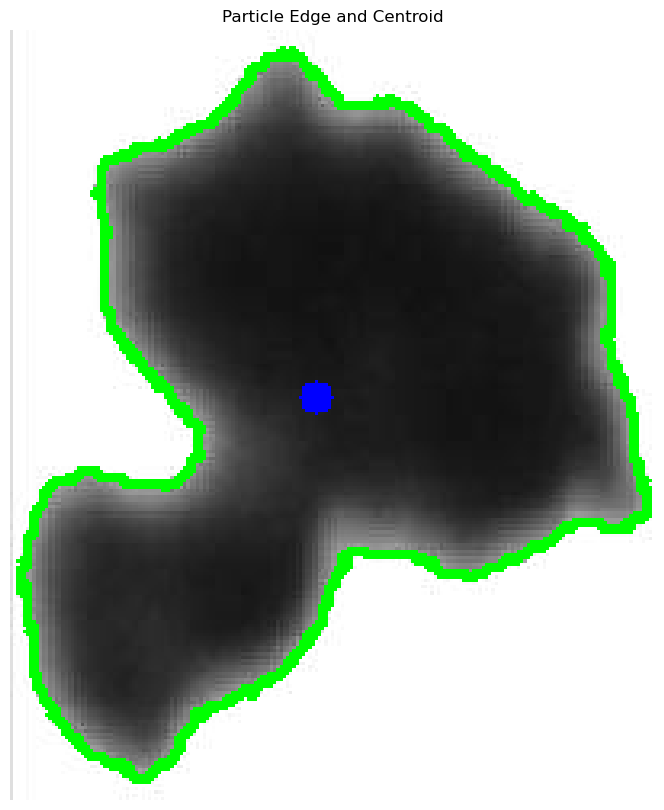

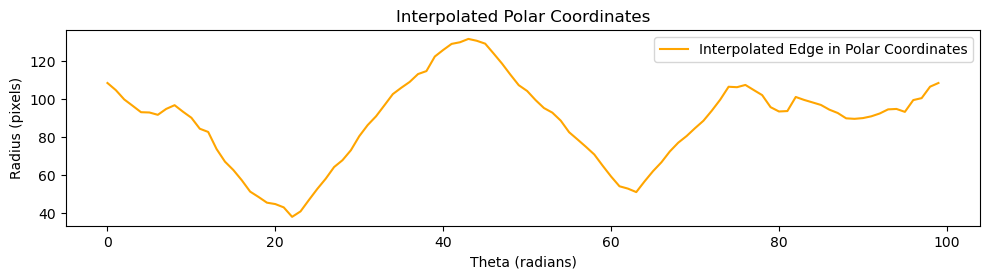

In [180]:
import cv2
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

def calculate_perimeter_and_centroid(image_path, threshold=170):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Threshold the image
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)

    # Find contours (perimeters)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming we want the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the centroid
    M = cv2.moments(largest_contour)
    centroid_x = int(M['m10'] / M['m00'])
    centroid_y = int(M['m01'] / M['m00'])
    centroid = np.array([centroid_x, centroid_y])

    # Create a parameterized description of the perimeter
    perimeter_points = np.array(largest_contour).reshape(-1, 2)

    return perimeter_points, centroid

def convert_to_polar(perimeter_points, centroid):
    # Convert Cartesian coordinates to polar coordinates
    polar_coords = []
    for point in perimeter_points:
        dx = point[0] - centroid[0]
        dy = point[1] - centroid[1]
        r = np.sqrt(dx**2 + dy**2)  # Radius
        theta = np.arctan2(dy, dx)   # Angle in radians
        polar_coords.append((r, theta))

    return np.array(polar_coords)

def interpolate_and_parameterize(polar_coords, interpolation_steps=100):
    # Extract radius and angle
    r = polar_coords[:, 0]
    theta = polar_coords[:, 1]

    # Create a 2D array for splprep
    points = np.array([theta, r])  # Shape should be (2, n)

    # Parameterizing using splprep
    tck, _ = splprep(points, s=0, per=True)

    # Generate interpolated values
    u = np.linspace(0, 1, interpolation_steps)
    interpolated_points = splev(u, tck)

    return np.array(interpolated_points[1]), np.array(interpolated_points[0])  # Return r and theta

def plot_results(image_path, perimeter_points, centroid, r_interp, theta_interp):
    # Load the original image
    image = cv2.imread(image_path)

    # Draw the original perimeter
    cv2.polylines(image, [perimeter_points], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Draw the centroid
    cv2.circle(image, tuple(centroid), 5, (255, 0, 0), -1)

    # Plot the image with perimeters and centroid
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Particle Edge and Centroid")
    plt.axis('off')

    # Plot interpolated polar coordinates
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(0,len(r_interp)), r_interp, label='Interpolated Edge in Polar Coordinates', color='orange')
    plt.title("Interpolated Polar Coordinates")
    plt.xlabel("Theta (radians)")
    plt.ylabel("Radius (pixels)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
image_path = 'image017.jpg'  # Ensure this is a valid path to your image
try:
    perimeter_points, centroid = calculate_perimeter_and_centroid(image_path)
    polar_coords = convert_to_polar(perimeter_points, centroid)
    r_interp, theta_interp = interpolate_and_parameterize(polar_coords)

    # Plot the results
    plot_results(image_path, perimeter_points, centroid, r_interp, theta_interp)
except Exception as e:
    print(f"An error occurred: {e}")


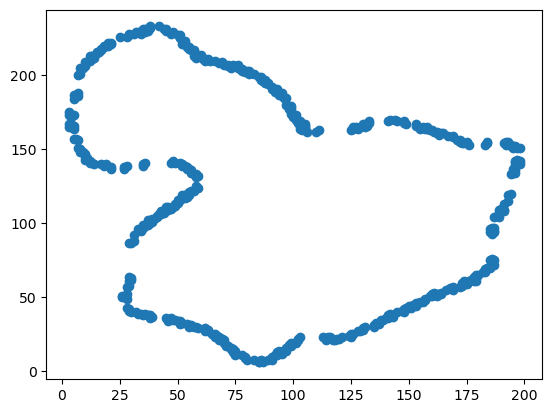

In [8]:
plt.scatter(original_perimeter[:, 0], original_perimeter[:, 1])

In [181]:
from PIL import Image
import numpy as np
import cv2

# Step 1: Load image, convert to grayscale, and apply threshold
def load_and_threshold_image(image_path, threshold_value=170):
    # Load image and convert to grayscale
    image = Image.open(image_path).convert('L')  # 'L' mode is for grayscale
    image_np = np.array(image)
    
    # Apply thresholding
    _, binary_image = cv2.threshold(image_np, threshold_value, 255, cv2.THRESH_BINARY)
    binary_image[np.where(binary_image == 0)] = 1  # Convert to binary (0 or 1)
    binary_image[np.where(binary_image == 255)] = 0  # Convert to binary (0 or 1)
    
    return binary_image

# Example of how to use this function:
image_path = 'image017.jpg'  # Path to your JPG file
binary_image = load_and_threshold_image(image_path)

# Display the binary image (optional)
# If you are running in a local environment, use OpenCV to display
# cv2.imshow('Binary Image', binary_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Step 1: Particle Boundary Representation (Continued from previous version)
def get_centroid(particle_image):
    # Find all non-zero pixels (i.e., particle)
    y, x = np.nonzero(particle_image)
    x_centroid = np.mean(x)
    y_centroid = np.mean(y)
    return x_centroid, y_centroid

def trace_perimeter(particle_image):
    # Use OpenCV to find contours
    contours, _ = cv2.findContours(particle_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Assuming the largest contour corresponds to the particle
    largest_contour = max(contours, key=cv2.contourArea)
    perimeter_coords = np.squeeze(largest_contour)  # Extract coordinates of the perimeter
    return perimeter_coords

def convert_to_polar(perimeter_coords, centroid):
    x_centroid, y_centroid = centroid
    R = np.sqrt((perimeter_coords[:, 0] - x_centroid)**2 + (perimeter_coords[:, 1] - y_centroid)**2)
    theta = np.arctan2(perimeter_coords[:, 1] - y_centroid, perimeter_coords[:, 0] - x_centroid)
    theta = np.unwrap(theta)  # Ensure continuity in the angle
    return R, theta

# Example usage for the whole step:
centroid = get_centroid(binary_image)
perimeter_coords = trace_perimeter(binary_image)
R, theta = convert_to_polar(perimeter_coords, centroid)

In [182]:
from scipy.interpolate import interp1d
import numpy as np

# Step 2: Interpolation for Equally Spaced Perimeter Increments
def compute_cumulative_perimeter_length(R, theta):
    # Compute cumulative perimeter length in the polar system
    # The incremental perimeter length dL between two points (R_i, theta_i) and (R_(i+1), theta_(i+1)) is
    # dL = sqrt(dR^2 + (R * dtheta)^2)
    dR = np.diff(R)
    dtheta = np.diff(theta)
    dL = np.sqrt(dR**2 + (R[:-1] * dtheta)**2)
    
    # Cumulative length of the perimeter
    L = np.concatenate([[0], np.cumsum(dL)])
    return L

def interpolate_perimeter(R, theta, num_points=500):
    # Step 1: Calculate cumulative perimeter length
    L = compute_cumulative_perimeter_length(R, theta)
    
    # Step 2: Interpolate R and theta along equally spaced perimeter increments
    L_uniform = np.linspace(0, L[-1], num_points)  # Generate equally spaced perimeter increments
    
    # Interpolation functions for R and theta based on the cumulative length
    R_interp_func = interp1d(L, R, kind='linear')
    theta_interp_func = interp1d(L, theta, kind='linear')
    
    # Get interpolated values for R and theta
    R_uniform = R_interp_func(L_uniform)
    theta_uniform = theta_interp_func(L_uniform)
    
    return R_uniform, theta_uniform,L_uniform

def mean_slope(theta, L):
    # Calculate the mean slope of the particle boundary
    # The slope is calculated as dR/dtheta
    mean_slope = -2*np.pi/np.max(L)
    return theta - mean_slope*L

# Example usage:
R_uniform, theta_uniform, L_uniform = interpolate_perimeter(R, theta, num_points=50)

# The result, R_uniform and theta_uniform, are now uniformly spaced based on the perimeter.

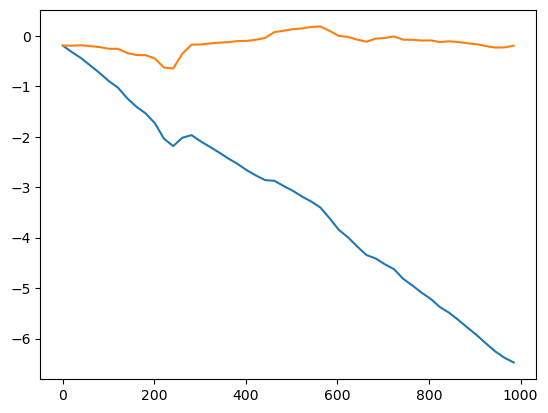

In [183]:
# plt.plot(L_uniform, R_uniform)
plt.plot(L_uniform, theta_uniform+theta_uniform[0]+np.pi)
plt.plot(L_uniform, mean_slope(theta_uniform+theta_uniform[0]+np.pi, L_uniform))

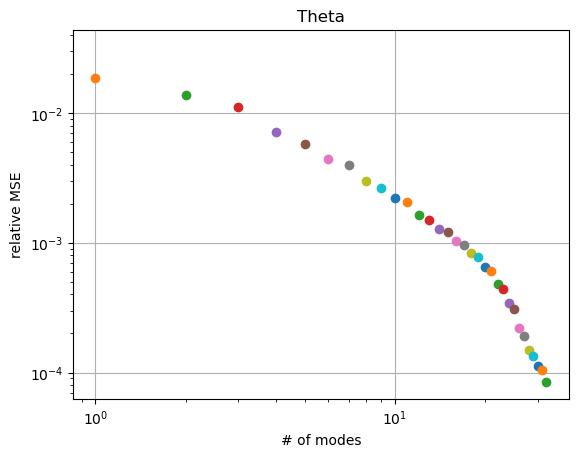

[ 0.          0.00099503  0.00199006  0.00298508  0.00398011  0.00497514
  0.00597017  0.00696519  0.00796022  0.00895525  0.00995028  0.0109453
  0.01194033  0.01293536  0.01393039  0.01492541  0.01592044  0.01691547
  0.0179105   0.01890552  0.01990055  0.02089558  0.02189061  0.02288563
  0.02388066 -0.02487569 -0.02388066 -0.02288563 -0.02189061 -0.02089558
 -0.01990055 -0.01890552 -0.0179105  -0.01691547 -0.01592044 -0.01492541
 -0.01393039 -0.01293536 -0.01194033 -0.0109453  -0.00995028 -0.00895525
 -0.00796022 -0.00696519 -0.00597017 -0.00497514 -0.00398011 -0.00298508
 -0.00199006 -0.00099503]


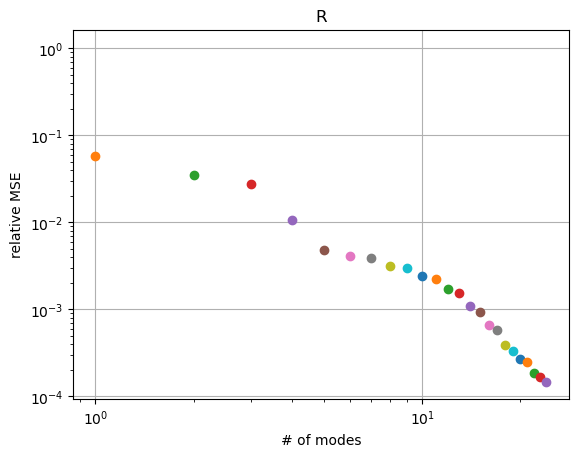

In [200]:
import numpy as np
import matplotlib.pyplot as plt


def fft_theta(theta, L, threshold):
    theta = theta - theta[0]  # Normalize theta
    # theta = theta + np.pi
    theta_mean = mean_slope(theta, L)
    # plt.plot(L, theta_mean, label='Mean Slope')
    theta_fft = np.fft.fft(theta_mean)

    freqs = np.fft.fftfreq(len(theta_mean), L[1] - L[0])  # Ensure L is properly defined

    # Sort the Fourier modes by their magnitude

    sorted_indices = np.argsort(-np.abs(theta_fft))
    


    # Reconstruct the signal using the largest Fourier mode
    theta_reconstructed =  np.zeros(theta_mean.shape)#-L*2*np.pi/np.max(L) + np.pi
    theta_fft_reconstructed = np.zeros_like(theta_fft)
    theta_fft_reconstructed[sorted_indices[0]] = theta_fft[sorted_indices[0]]
    difference = theta_mean - theta_reconstructed
    mse = np.mean(difference**2)
    # plt.plot(L, theta_reconstructed, label='1 mode')
    plt.loglog(0,mse, 'o')


    i = 1
    while mse > threshold and i < len(sorted_indices):
        theta_fft_reconstructed = np.zeros_like(theta_fft)
        theta_fft_reconstructed[sorted_indices[:i]] = theta_fft[sorted_indices[:i]]
        theta_reconstructed = np.fft.ifft(theta_fft_reconstructed).real
        difference = theta_mean - theta_reconstructed
        mse = np.mean(difference**2)
        # plt.plot(L, theta_reconstructed, label=f'{i} modes')
        plt.loglog(i,mse, 'o')
        i += 1
        
    plt.xlabel('# of modes')
    plt.ylabel('relative MSE')
    plt.title('Theta')
    # plt.title('MSE vs Number of Fourier Modes')
    plt.grid()
    plt.show()
    
    return theta_reconstructed, theta_fft_reconstructed

def fft_r(R, L, threshold):
    # R_mean = np.mean(R)
    R_fft = np.fft.fft(R)

    freqs = np.fft.fftfreq(len(R), L[1] - L[0])  # Ensure L is properly defined
    print(freqs)
    # Sort the Fourier modes by their magnitude
    sorted_indices = np.argsort(-np.abs(R_fft))

    # Reconstruct the signal using the largest Fourier mode
    R_reconstructed = np.zeros(R.shape)
    R_fft_reconstructed = np.zeros_like(R_fft)
    R_fft_reconstructed[sorted_indices[0]] = R_fft[sorted_indices[0]]
    difference = R - R_reconstructed
    mse = np.mean(difference**2)
    # plt.plot(L, R_reconstructed, label='1 mode')
    plt.loglog(0,mse/np.mean(R)**2, 'o')

    i = 1
    while mse > threshold and i < len(sorted_indices):
        R_fft_reconstructed = np.zeros_like(R_fft)
        R_fft_reconstructed[sorted_indices[:i]] = R_fft[sorted_indices[:i]]
        R_reconstructed = np.fft.ifft(R_fft_reconstructed).real
        difference = R - R_reconstructed
        mse = np.mean(difference**2)
        # plt.plot(L, R_reconstructed, label=f'{i} modes')
        plt.loglog(i,mse/np.mean(R)**2, 'o')
        i += 1

    if i == len(sorted_indices):
        print('Threshold not reached')
    if i == 1:
        print('Threshold reached with 1 mode')
    plt.xlabel('# of modes')
    plt.ylabel('relative MSE')
    plt.title('R')
    # plt.title('MSE vs Number of Fourier Modes')
    plt.grid()
    plt.show()

    return R_reconstructed, R_fft_reconstructed

# Example usage:
threshold = 1E-4
# Ensure theta_uniform and L_uniform are defined here
theta_reconstructed, theta_fft_reconstructed = fft_theta(theta_uniform, L_uniform, threshold)
R_reconstructed, R_fft_reconstructed = fft_r(R_uniform, L_uniform, threshold = 1E-2*max(R_uniform))


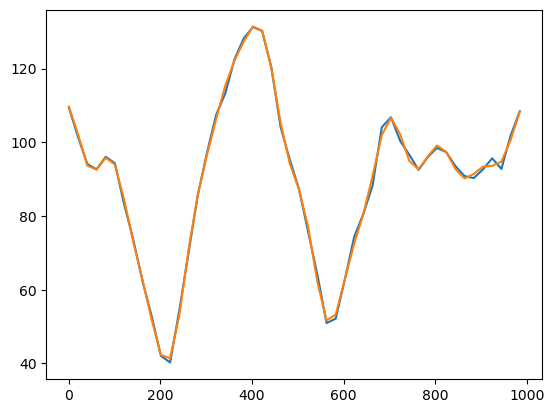

In [196]:
plt.plot(L_uniform, R_uniform)
plt.plot(L_uniform, R_reconstructed)


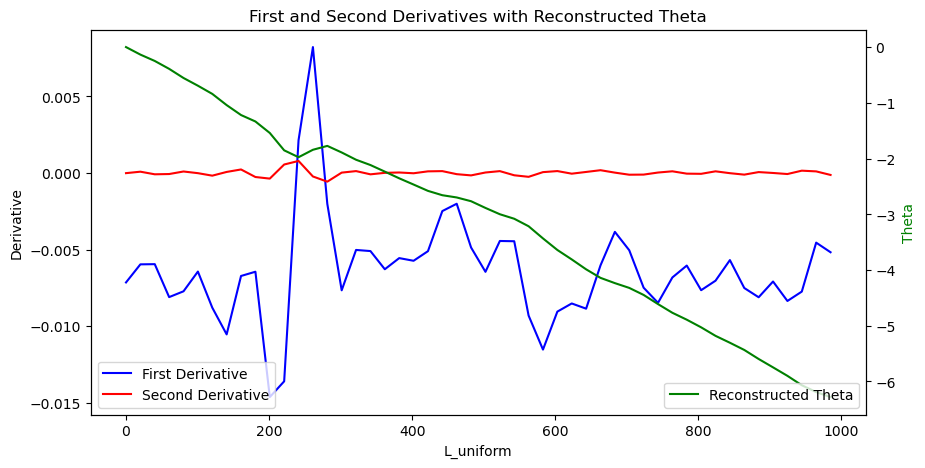

In [203]:
import numpy as np

def compute_derivatives(fourier_coeffs, L):
    """
    Compute the exact first and second derivatives given a set of Fourier series coefficients.

    Parameters:
    - fourier_coeffs: numpy.ndarray
        The Fourier series coefficients.
    - L: float
        The length of the interval over which the Fourier series is defined.

    Returns:
    - first_derivative_coeffs: numpy.ndarray
        The Fourier series coefficients of the first derivative.
    - second_derivative_coeffs: numpy.ndarray
        The Fourier series coefficients of the second derivative.
    """
    N = len(fourier_coeffs)
    k = np.fft.fftfreq(N, d=L/N)* 2 * np.pi  # Frequency indices

    # Compute the Fourier coefficients for the first derivative
    first_derivative_coeffs = 1j * k * fourier_coeffs

    # Compute the Fourier coefficients for the second derivative
    second_derivative_coeffs = -k**2 * fourier_coeffs

    return first_derivative_coeffs, second_derivative_coeffs

# Example usage:
# Assuming `theta_fft_reconstructed` contains the Fourier series coefficients of the function
L = L_uniform[-1]  # Length of the interval
first_derivative_coeffs, second_derivative_coeffs = compute_derivatives(theta_fft_reconstructed, L)

# To get the derivatives in the time domain, perform the inverse FFT
theta_first_derivative = np.fft.ifft(first_derivative_coeffs).real
theta_second_derivative = np.fft.ifft(second_derivative_coeffs).real

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first and second derivatives on the first y-axis
ax1.plot(L_uniform, theta_first_derivative - 2*np.pi/np.max(L_uniform), label='First Derivative', color='blue')
ax1.plot(L_uniform, theta_second_derivative, label='Second Derivative', color='red')
ax1.set_xlabel('L_uniform')
ax1.set_ylabel('Derivative')
ax1.legend(loc='lower left')

# Create a second y-axis to plot the reconstructed theta
ax2 = ax1.twinx()
ax2.plot(L_uniform, theta_reconstructed - 2*np.pi*L_uniform/np.max(L), label='Reconstructed Theta', color='green')
ax2.set_ylabel('Theta', color='green')
ax2.legend(loc='lower right')

plt.title('First and Second Derivatives with Reconstructed Theta')
plt.show()

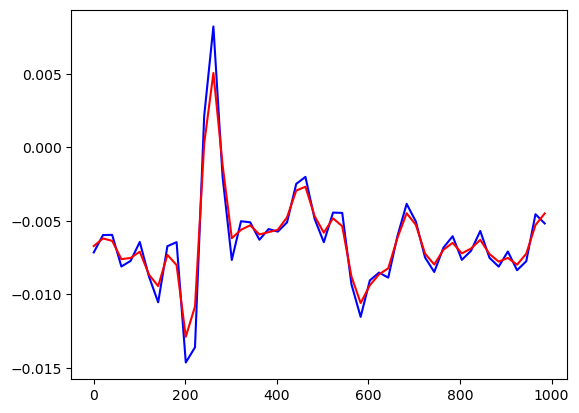

In [210]:
plt.plot(L_uniform, theta_first_derivative - 2*np.pi/np.max(L_uniform), label='First Derivative', color='blue')
plt.plot(L_uniform, np.gradient(theta_reconstructed-2*np.pi*L_uniform/np.max(L), L_uniform), label='First Derivative', color='red')


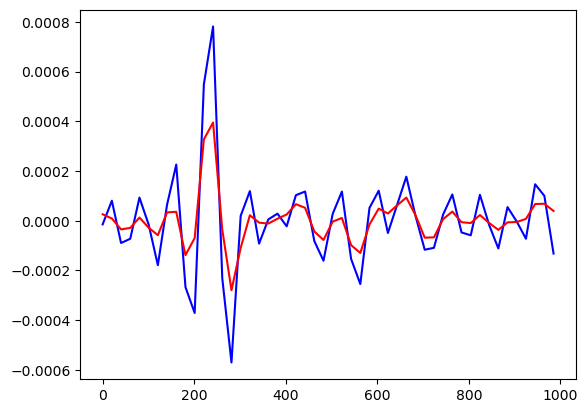

In [212]:
plt.plot(L_uniform, theta_second_derivative, label='First Derivative', color='blue')
plt.plot(L_uniform, np.gradient(np.gradient(theta_reconstructed-2*np.pi*L_uniform/np.max(L), L_uniform), L_uniform), label='First Derivative', color='red')

[ 0.          0.00099503  0.00199006  0.00298508  0.00398011  0.00497514
  0.00597017  0.00696519  0.00796022  0.00895525  0.00995028  0.0109453
  0.01194033  0.01293536  0.01393039  0.01492541  0.01592044  0.01691547
  0.0179105   0.01890552  0.01990055  0.02089558  0.02189061  0.02288563
  0.02388066 -0.02487569 -0.02388066 -0.02288563 -0.02189061 -0.02089558
 -0.01990055 -0.01890552 -0.0179105  -0.01691547 -0.01592044 -0.01492541
 -0.01393039 -0.01293536 -0.01194033 -0.0109453  -0.00995028 -0.00895525
 -0.00796022 -0.00696519 -0.00597017 -0.00497514 -0.00398011 -0.00298508
 -0.00199006 -0.00099503]


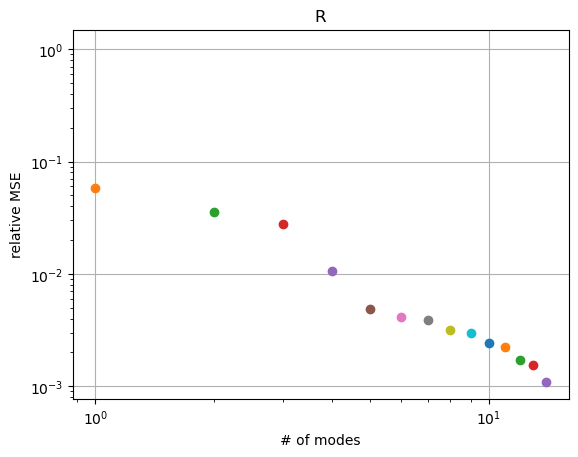

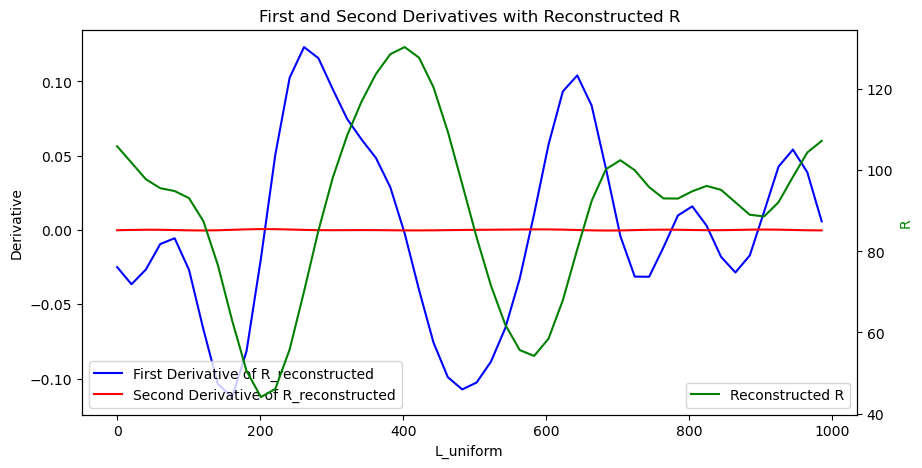

In [202]:
import numpy as np
import matplotlib.pyplot as plt


R_reconstructed, R_fft_reconstructed = fft_r(R_uniform, L_uniform, threshold = 10)

# Assuming `R_reconstructed`, `L_uniform`, `first_derivative`, and `second_derivative` are already defined

# Compute the first and second derivatives of R_reconstructed
# Compute the Fourier coefficients for the first and second derivatives of R_reconstructed
first_derivative_coeffs_R, second_derivative_coeffs_R = compute_derivatives(R_fft_reconstructed, L)

# To get the derivatives in the time domain, perform the inverse FFT
first_derivative_R = np.fft.ifft(first_derivative_coeffs_R).real
second_derivative_R = np.fft.ifft(second_derivative_coeffs_R).real

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first and second derivatives on the first y-axis
ax1.plot(L_uniform, first_derivative_R, label='First Derivative of R_reconstructed', color='blue')
ax1.plot(L_uniform, second_derivative_R, label='Second Derivative of R_reconstructed', color='red')
ax1.set_xlabel('L_uniform')
ax1.set_ylabel('Derivative')
ax1.legend(loc='lower left')

# Create a second y-axis to plot the reconstructed R
ax2 = ax1.twinx()
ax2.plot(L_uniform, R_reconstructed, label='Reconstructed R', color='green')
ax2.set_ylabel('R', color='green')
ax2.legend(loc='lower right')

plt.title('First and Second Derivatives with Reconstructed R')
plt.show()

(-5.0, 5.0)

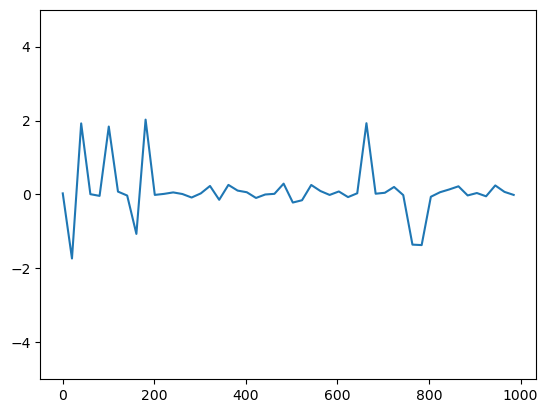

In [215]:
def calculate_kappa(R_prime, R, R_double_prime, theta_prime, theta_double_prime):
    # Ensure input arrays are numpy arrays for element-wise operations
    R_prime = np.array(R_prime)
    R = np.array(R)
    R_double_prime = np.array(R_double_prime)
    theta_prime = np.array(theta_prime)
    theta_double_prime = np.array(theta_double_prime)

    # Calculate the numerator of the kappa formula
    numerator = (2 * R_prime**2 * theta_prime +
                 R_prime * R * theta_double_prime -
                 R_double_prime * R * theta_prime +
                 R**2 * theta_prime**3)

    # Calculate the denominator of the kappa formula
    denominator = (R_prime**2 + R**2 * theta_prime**2)**(3/2)

    # Calculate kappa
    kappa = numerator / denominator

    return kappa

kappa = calculate_kappa(first_derivative_R, R_reconstructed, second_derivative_R, theta_first_derivative,theta_second_derivative)

plt.plot(L_uniform, kappa)
plt.ylim(-5, 5)

In [191]:
from scipy.stats import skew
print(1/np.mean(kappa), np.mean(R), skew(kappa), np.std(kappa)/np.mean(kappa))

19.878938612270087 89.25612047624013 0.36915662881626704 7.504977384173048


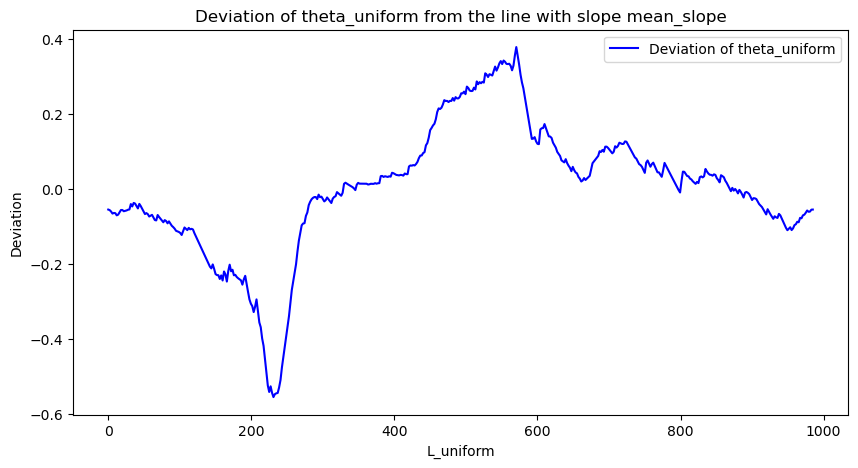

In [38]:
mean_slope = np.mean(np.diff(theta_uniform) / np.diff(L_uniform))
# Calculate the deviation of theta_uniform from the line with slope mean_slope
theta_fit = mean_slope * L_uniform
deviation = theta_uniform - theta_fit

deviation = deviation - np.mean(deviation)

# Plot the deviation
plt.figure(figsize=(10, 5))
plt.plot(L_uniform, deviation, label='Deviation of theta_uniform', color='blue')
plt.xlabel('L_uniform')
plt.ylabel('Deviation')
plt.title('Deviation of theta_uniform from the line with slope mean_slope')
plt.legend()
plt.show()

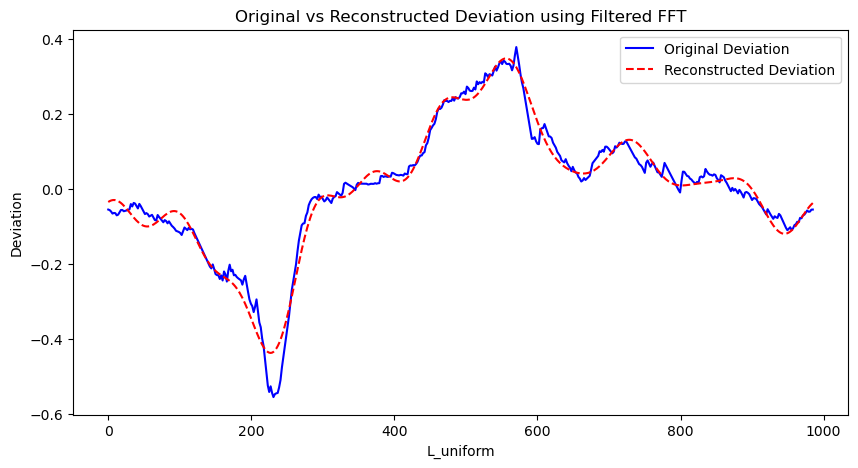

In [43]:
# Compute the FFT of the deviation
fft_deviation = np.fft.fft(deviation)

# Define a threshold for the Fourier modes
threshold = 5  # You can adjust this threshold as needed

# Filter the Fourier coefficients
filtered_fft_deviation = np.where(np.abs(fft_deviation) > threshold, fft_deviation, 0)

# Reconstruct the signal by performing an inverse FFT
reconstructed_deviation = np.fft.ifft(filtered_fft_deviation)

# Plot the original and reconstructed deviation for comparison
plt.figure(figsize=(10, 5))
plt.plot(L_uniform, deviation, label='Original Deviation', color='blue')
plt.plot(L_uniform, reconstructed_deviation.real, label='Reconstructed Deviation', color='red', linestyle='--')
plt.xlabel('L_uniform')
plt.ylabel('Deviation')
plt.title('Original vs Reconstructed Deviation using Filtered FFT')
plt.legend()
plt.show()

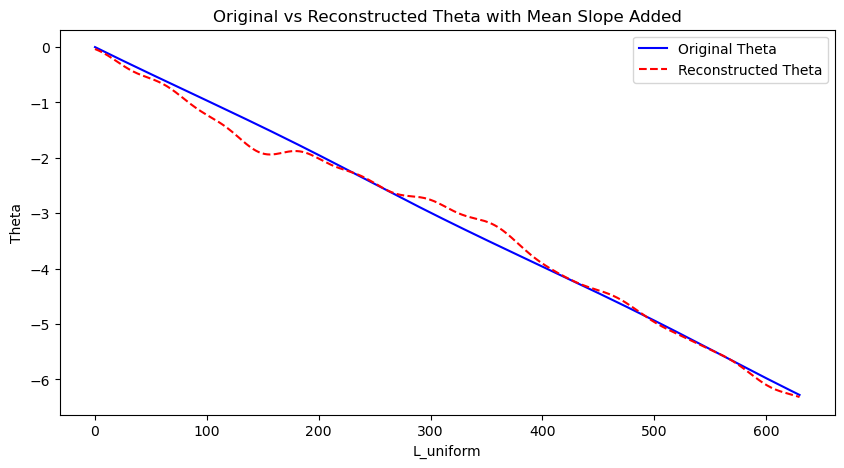

In [161]:
# Add the mean slope back to the reconstructed deviation
theta_reconstructed = reconstructed_deviation.real + theta_fit

# Plot the original and reconstructed theta vs L
plt.figure(figsize=(10, 5))
plt.plot(L_uniform, theta_uniform, label='Original Theta', color='blue')
plt.plot(L_uniform, theta_reconstructed, label='Reconstructed Theta', color='red', linestyle='--')
plt.xlabel('L_uniform')
plt.ylabel('Theta')
plt.title('Original vs Reconstructed Theta with Mean Slope Added')
plt.legend()
plt.show()

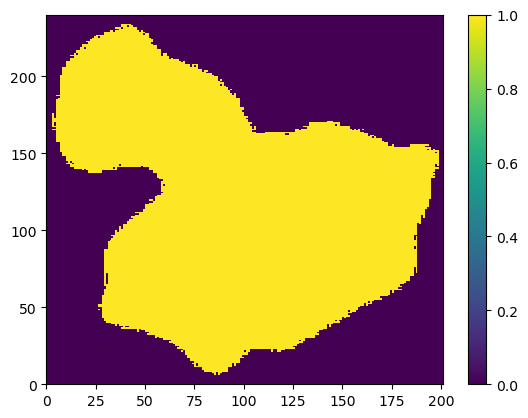

In [25]:
plt.pcolormesh(binary_image)
plt.colorbar()

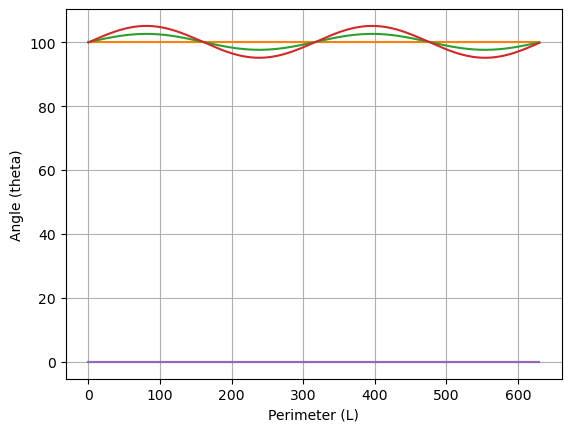

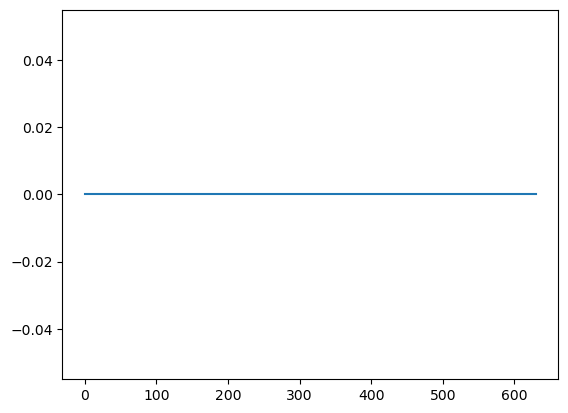

In [154]:
# idealized_case

r = 100 + 5 * np.sin(2*np.linspace(0, 2 * np.pi, 100))
theta = np.linspace(0, -2*np.pi, 100)
theta = theta
# theta = theta 
# L = np.linspace(0, 2*np.pi, 100)

R_uniform, theta_uniform, L_uniform = interpolate_perimeter(r, theta, num_points=500)

R_reconstructed, R_fft_reconstructed = fft_r(R_uniform, L_uniform, threshold = 1E-2)


theta_reconstructed, theta_fft_reconstructed = fft_theta(theta_uniform, L_uniform, threshold = 1E-2)

first_derivative_coeffs_R, second_derivative_coeffs_R = compute_derivatives(R_fft_reconstructed, L)

# To get the derivatives in the time domain, perform the inverse FFT
first_derivative_R = np.fft.ifft(first_derivative_coeffs_R).real
second_derivative_R = np.fft.ifft(second_derivative_coeffs_R).real


first_derivative_coeffs_theta, second_derivative_coeffs_theta = compute_derivatives(theta_fft_reconstructed, L)


first_derivative_theta = np.fft.ifft(first_derivative_coeffs_theta).real
second_derivative_theta = np.fft.ifft(second_derivative_coeffs_theta).real

kappa = calculate_kappa(first_derivative_R, R_reconstructed, second_derivative_R, first_derivative_theta, second_derivative_theta)

plt.plot(L_uniform, kappa)



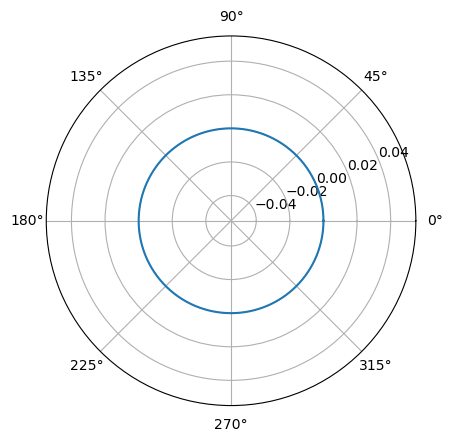

In [156]:
plt.polar(theta_uniform, kappa)